# Image classification: dogs & cats

In [1]:
# Handle imports up-front
import glob
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from utils import make_datasets
from utils import compile_model



2024-12-05 00:16:17.547482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Set the path to the training data
training_data_path='../data/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

### 1.2. Inspect

In [3]:
import os
import shutil
# Define the directories for train and test data
train_dir = "/workspaces/m27gperdrizet-image-classification-project/data/train"
test_dir = "/workspaces/m27gperdrizet-image-classification-project/data/test"
# Function to split images into subdirectories based on class
def split_into_subdirectories(directory):
    # Get the list of image files in the directory
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # Create subdirectories for each class
    for image_file in image_files:
        # Determine the class label based on the filename
        class_label = "dog" if "dog" in image_file else "cat"
        # Create the subdirectory if it doesn't exist
        class_dir = os.path.join(directory, class_label)
        os.makedirs(class_dir, exist_ok=True)
        # Move the image file to the corresponding subdirectory
        src = os.path.join(directory, image_file)
        dst = os.path.join(class_dir, image_file)
        shutil.move(src, dst)
# Split train data into subdirectories
split_into_subdirectories(train_dir)
# Split test data into subdirectories
split_into_subdirectories(test_dir)

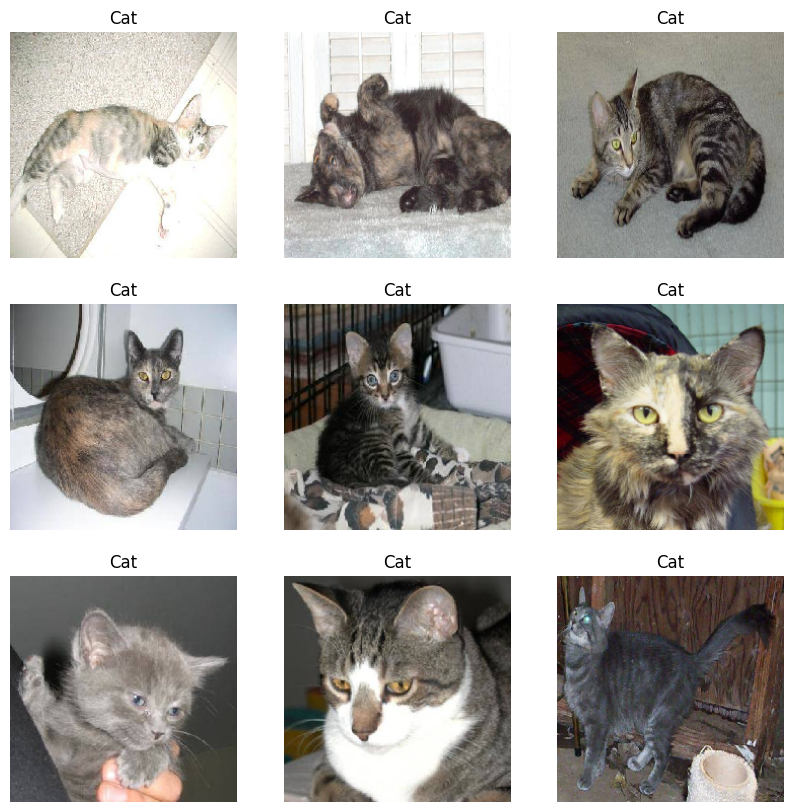

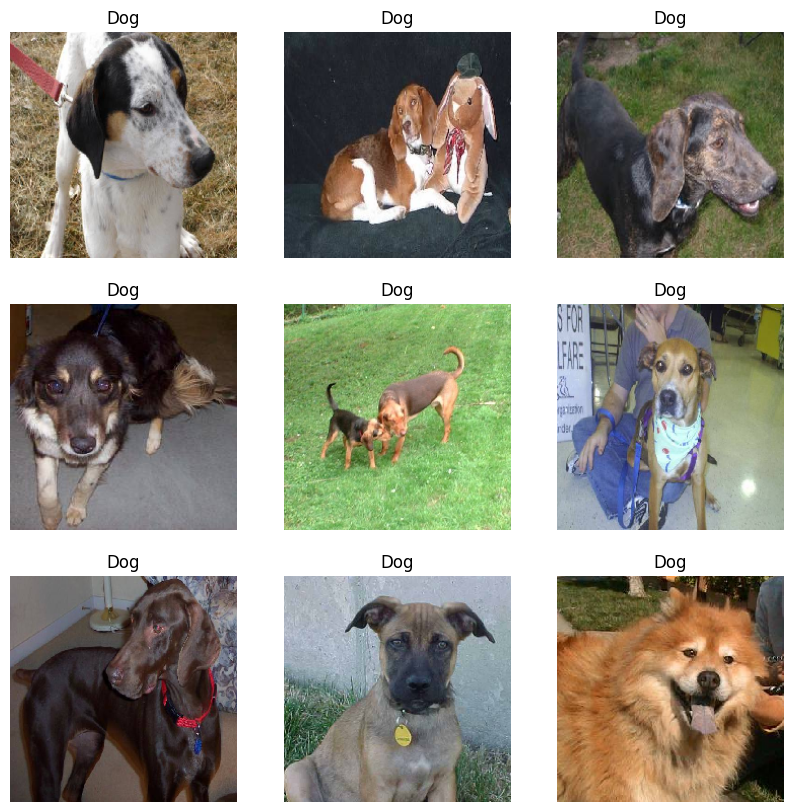

In [4]:
# Define the directories for cat and dog images
cat_dir = '/workspaces/m27gperdrizet-image-classification-project/data/train/cat/'
dog_dir = '/workspaces/m27gperdrizet-image-classification-project/data/train/dog/'

# Get the file names for cats and dogs
cat_files = [cat_dir + filename for filename in os.listdir(cat_dir)][:9]
dog_files = [dog_dir + filename for filename in os.listdir(dog_dir)][:9]

# Function to display images
def display_images(image_files, title):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = image.load_img(image_files[i], target_size=(224, 224))
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Display the first nine images of cats
display_images(cat_files, 'Cat')

# Display the first nine images of dogs
display_images(dog_files, 'Dog')

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [5]:
# Load one of the dogs
dog=image.load_img(dog_files[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (375, 499, 3)


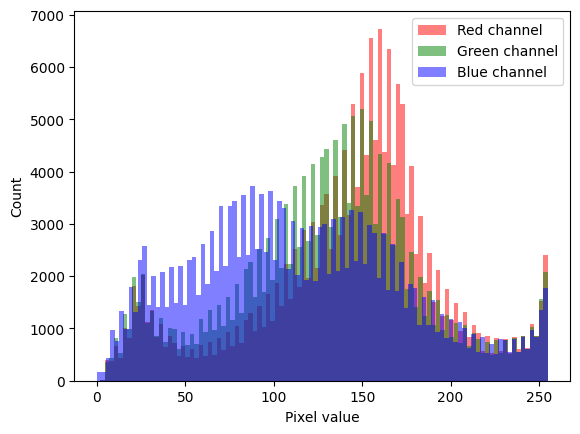

In [6]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

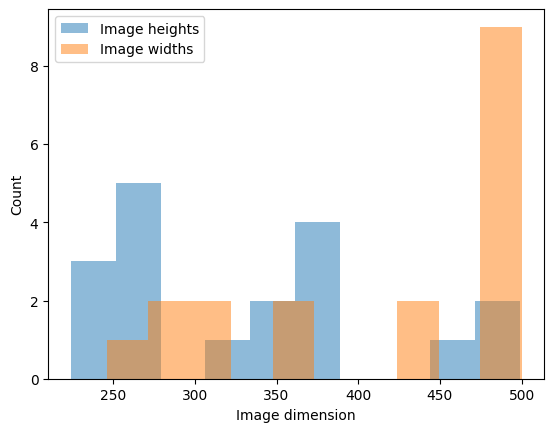

In [7]:
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
# Combine all available images
sample = dog_files + cat_files
# Initialize lists for dimensions
heights = []
widths = []
# Loop through the sample images
for sample_image_path in sample:
    if os.path.exists(sample_image_path):  # Ensure file exists
        try:
            img = image.load_img(sample_image_path)
            img_array = image.img_to_array(img)
            heights.append(img_array.shape[0])
            widths.append(img_array.shape[1])
        except Exception as e:
            print(f"Error loading {sample_image_path}: {e}")
    else:
        print(f"File not found: {sample_image_path}")
# Check if lists are populated
if heights and widths:
    # Plot histograms of heights and widths
    plt.hist(heights, bins=10, alpha=0.5, label='Image heights')
    plt.hist(widths, bins=10, alpha=0.5, label='Image widths')
    plt.xlabel('Image dimension')
    plt.ylabel('Count')
    plt.legend(loc='best')
    plt.show()
else:
    print("No valid images found for plotting.")

In [8]:
image_dim=128

### 2.3. Image aspect ratios

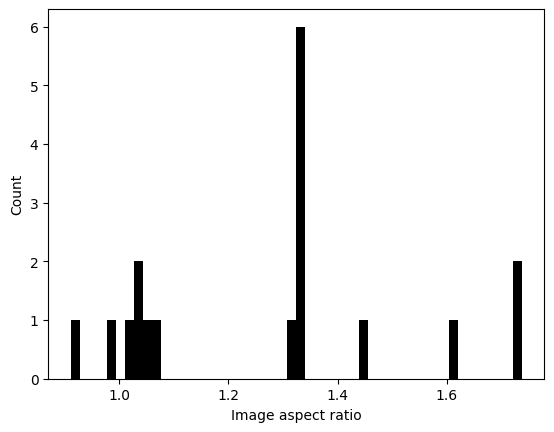

In [9]:
aspect_ratios=np.array(widths)/np.array(heights)

plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

In [10]:
image_width=image_dim
image_height=int(image_dim / (4/3))
print(f'Image input dimensions: {image_width} x {image_height}')

Image input dimensions: 128 x 96


## 3. Build the model

### 3.1. Prepare images for streaming

### 3.1. Model definition

In [11]:
training_dataset, validation_dataset = make_datasets(training_data_path, image_dim, image_dim, 8)
model=compile_model(training_dataset, image_dim, image_dim, 0.001,  0 , 0  )
model.summary()

Found 81 files belonging to 2 classes.
Using 65 files for training.
Found 81 files belonging to 2 classes.
Using 16 files for validation.


2024-12-05 00:16:22.913664: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 128, 128, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,672 (6.25 MB)

 Trainable params: 1,637,665 (6.25 MB)

 Non-trainable params: 7 (32.00 B)

In [12]:
training_dataset, validation_dataset = make_datasets(training_data_path, image_dim, image_dim, 8)

Found 81 files belonging to 2 classes.
Using 65 files for training.
Found 81 files belonging to 2 classes.
Using 16 files for validation.


### 3.2. Model training

In [13]:
training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=5
)

Epoch 1/10
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - binary_accuracy: 0.5764 - loss: 0.8198

2024-12-05 00:16:24.715988: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24385536 exceeds 10% of free system memory.
2024-12-05 00:16:24.731607: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25719552 exceeds 10% of free system memory.
2024-12-05 00:16:24.752199: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20575296 exceeds 10% of free system memory.
2024-12-05 00:16:24.794110: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24385536 exceeds 10% of free system memory.
2024-12-05 00:16:24.803884: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25719552 exceeds 10% of free system memory.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - binary_accuracy: 0.5809 - loss: 0.9080 - val_binary_accuracy: 0.5625 - val_loss: 0.7119
Epoch 2/10
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - binary_accuracy: 0.3125 - loss: 0.8561

2024-12-05 00:16:25.224441: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - binary_accuracy: 0.2953 - loss: 0.9136 - val_binary_accuracy: 0.6875 - val_loss: 0.6439
Epoch 3/10


2024-12-05 00:16:25.562398: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.4483 - loss: 0.7111 - val_binary_accuracy: 0.3750 - val_loss: 0.7050
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - binary_accuracy: 0.6893 - loss: 0.6497 - val_binary_accuracy: 0.3750 - val_loss: 0.7084
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - binary_accuracy: 0.7747 - loss: 0.6252 - val_binary_accuracy: 0.5625 - val_loss: 0.6802
Epoch 6/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - binary_accuracy: 0.6250 - loss: 0.5981

2024-12-05 00:16:27.664394: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - binary_accuracy: 0.7040 - loss: 0.5824 - val_binary_accuracy: 0.5000 - val_loss: 0.6363
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - binary_accuracy: 0.7260 - loss: 0.5673 - val_binary_accuracy: 0.5000 - val_loss: 0.8073
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.6887 - loss: 0.5501 - val_binary_accuracy: 0.6875 - val_loss: 0.6663
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - binary_accuracy: 0.7878 - loss: 0.4781 - val_binary_accuracy: 0.6875 - val_loss: 0.5677
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 1.0000 - loss: 0.3550 - val_binary_accuracy: 0.3750 - val_loss: 0.7016


2024-12-05 00:16:29.473133: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


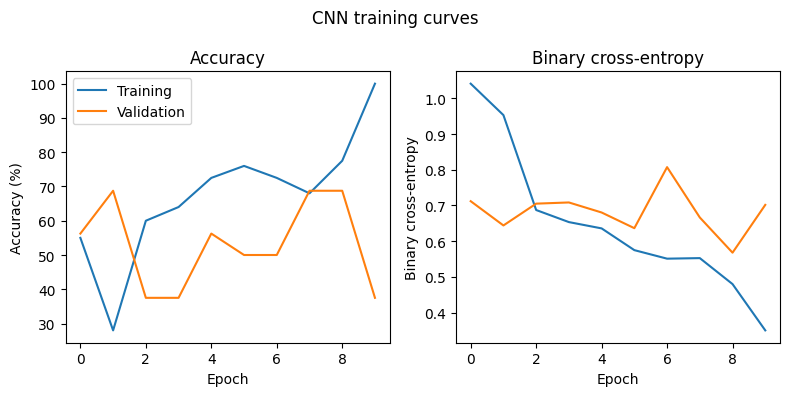

In [14]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
plt.tight_layout()
plt.show()

### 3.3. Model optimization

In [15]:
import tensorflow as tf
import itertools
# Example hyperparameters
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [64, 128, 256]
training_results = []
# Generate combinations of parameters
conditions = list(itertools.product(batch_sizes, learning_rates))
for i, parameters in enumerate(conditions):
    batch_size, learning_rate = parameters
    print(f'\nStarting training run {i + 1} of {len(conditions)}: batch size: {batch_size}, learning rate: {learning_rate}')
    # Create datasets
    training_dataset, validation_dataset = make_datasets(training_data_path, image_width, image_height, batch_size)
    model = compile_model(training_dataset, image_dim, image_dim, learning_rate,  0 , 0  )
    # Define early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    # Train the model
    training_result = model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=10,
        steps_per_epoch=20,
        validation_steps=20,
        callbacks=[early_stopping]
    )
    training_results.append(training_result)


Starting training run 1 of 9: batch size: 64, learning rate: 0.001
Found 81 files belonging to 2 classes.
Using 65 files for training.
Found 81 files belonging to 2 classes.
Using 16 files for validation.
Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 12544, but received input with shape (None, 8960)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 96, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Pick the best values for learning rate and batch size and train the model for longer

## 4. Evaluate the model

In [ ]:
# Test the model out on the test data - is it as good as you expected, given the training data? Worse? Better? Why?